In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

df = sns.load_dataset('flights')

In [2]:
df.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


In [3]:
# construct a timestamp

ts = df['year'].astype(str) + ' ' + df['month'].astype(str)
ts = pd.to_datetime(ts)

In [4]:
df.set_index(ts, inplace=True)

In [5]:
df.head()

,year,month,passengers
1949-01-01,1949,January,112
1949-02-01,1949,February,118
1949-03-01,1949,March,132
1949-04-01,1949,April,129
1949-05-01,1949,May,121


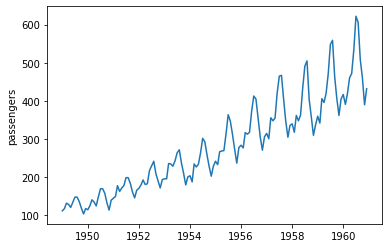

In [6]:
sns.lineplot(x=df.index, y='passengers', data=df)

## Straight forward LinReg

In [7]:
X = df.index.values.reshape(-1,1).astype(int) # time stamps are really integers! Models often cannot work with timestamps.
y = df['passengers']

In [8]:
X.shape, y.shape

((144, 1), (144,))

In [9]:
from sklearn.linear_model import LinearRegression

m = LinearRegression()
m.fit(X, y)
m.score(X, y) # R^2 value - not an accuracy

0.8535045786367348

In [10]:
df['ypred'] = m.predict(X)

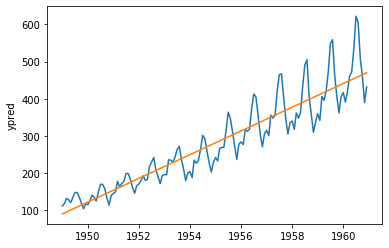

In [11]:
sns.lineplot(x=df.index, y='passengers', data=df)
sns.lineplot(x=df.index, y='ypred', data=df)

## Feature Engineering

In [12]:
df.head()

,year,month,passengers,ypred
1949-01-01,1949,January,112,90.418495
1949-02-01,1949,February,118,93.124574
1949-03-01,1949,March,132,95.568773
1949-04-01,1949,April,129,98.274851
1949-05-01,1949,May,121,100.893636


In [13]:
# one-hot encoding
months = pd.get_dummies(df['month'])
df = pd.concat([df, months], axis=1)

In [14]:
# Factorizing
df['month_fact'] = pd.factorize(df['month'])[0]

In [38]:
df['month_fact2'] = np.abs(df['month_fact'] - 6)

In [39]:
df.head()

,year,month,passengers,ypred,January,February,March,April,May,June,July,August,September,October,November,December,month_fact,month_fact2,ts,ts_norm
1949-01-01,1949,January,112,44.861560,1,0,0,0,0,0,0,0,0,0,0,0,0,6,-662688000000000000,-662.6880
1949-02-01,1949,February,118,60.012210,0,1,0,0,0,0,0,0,0,0,0,0,1,5,-660009600000000000,-660.0096
1949-03-01,1949,March,132,74.904115,0,0,1,0,0,0,0,0,0,0,0,0,2,4,-657590400000000000,-657.5904
1949-04-01,1949,April,129,90.054766,0,0,0,1,0,0,0,0,0,0,0,0,3,3,-654912000000000000,-654.9120
1949-05-01,1949,May,121,105.119168,0,0,0,0,1,0,0,0,0,0,0,0,4,2,-652320000000000000,-652.3200


In [40]:
df['ts'] = df.index.values.reshape(-1,1).astype(int)

In [41]:
X = df[['ts', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September','October', 'November', 'December']] # time stamps are really integers! Models often cannot work with timestamps.
y = df['passengers']

In [42]:
from sklearn.linear_model import LinearRegression

m = LinearRegression()
m.fit(X, y)
m.score(X, y) # R^2 value - not an accuracy

0.8535045786367348

In [43]:
df['ypred'] = m.predict(X)

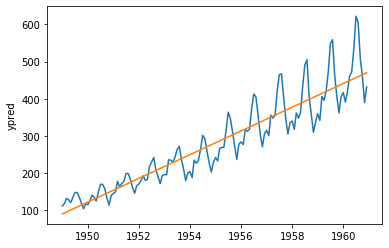

In [44]:
sns.lineplot(x=df.index, y='passengers', data=df)
sns.lineplot(x=df.index, y='ypred', data=df)

Why doesn't it work here? Precision issues! ts has too many digits! Like: Weighing the captain by weighing the ship with and without the captain. How do we solve that? Normalization!

In [45]:
# or just shift the comma
df['ts_norm'] = df['ts'] / 1_000_000_000_000_000

In [57]:
X = df[['ts_norm', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September','October', 'November', 'December']] # time stamps are really integers! Models often cannot work with timestamps.
y = df['passengers']

In [58]:
m.fit(X, y)
m.score(X, y)

0.9558864945293956

In [59]:
df['ypred'] = m.predict(X)

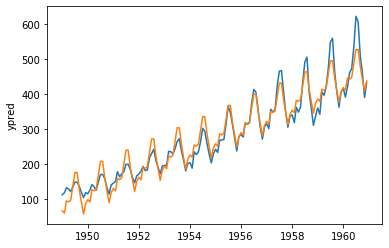

In [60]:
sns.lineplot(x=df.index, y='passengers', data=df)
sns.lineplot(x=df.index, y='ypred', data=df)

## Feature Engineering

* one-hot encoding
* factorization
* factorization with a peak
* normalize (scale)

#### Other Feature Expansion Techniques

* log_transformation
* interaction terms (maybe for hours on weekdays vs weekends)
* polynomial features
* radial base function (advanced, deluxe one-hot encoding)

## Feature engineering both, train + test

In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # scales each column to minimum 0.0 and maximum 1.0. Makes sure all data fits together.
scaler.fit(X)
X_scaled = scaler.transform(X) # later just use transform on X_test, DO NOT FIT AGAIN

In [64]:
from sklearn.preprocessing import OneHotEncoder
ohc = OneHotEncoder()
ohc.fit(df[['month']])
month_ohc = ohc.transform(df[['month']])

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]])

In [65]:
month_ohc.todense() # todense() helps showing sparse data with many zeros

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]])

In [ ]:
# 

def fe(X):
    X1 = scaler.transform(X)
    X2 = ohc.transform(X)